# 04-3 BERT 후속 모델로 영화 리뷰 텍스트의 감성 분류하기

*이 노트북은 코랩의 A100 GPU 런타임으로 테스트했습니다.*

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/hm-dl/blob/main/04-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

04-1절에서 정의한 `transformer_encoder()` 함수를 재사용합니다.

In [1]:
# x는 토큰 임베딩과 위치 임베딩을 더한 값입니다.
def transformer_encoder(x, padding_mask, dropout, activation='relu'):
    residual = x
    key_dim = hidden_dim // num_heads
    # 멀티 헤드 어텐션을 통과합니다.
    x = layers.MultiHeadAttention(num_heads, key_dim, dropout=dropout)(
        query=x, value=x, attention_mask=padding_mask)
    x = layers.Dropout(dropout)(x)
    # 스킵 연결
    x = x + residual
    x = layers.LayerNormalization()(x)
    residual = x
    # 위치별 피드 포워드 네트워크
    x = layers.Dense(hidden_dim * 4, activation=activation)(x)
    x = layers.Dense(hidden_dim)(x)
    x = layers.Dropout(dropout)(x)
    # 스킵 연결
    x = x + residual
    x = layers.LayerNormalization()(x)
    return x

## BERT의 성능 개선 모델 - RoBERTa

### KerasNLP로 RoBERTa 모델 만들기

In [2]:
import keras
from keras import layers
import keras_nlp

# RoBERTa 백본
vocab_size = 50265
num_layers = 12
num_heads = 12
hidden_dim = 768
dropout = 0.1
activation = 'gelu'
max_seq_len = 512

token_ids = keras.Input(shape=(None,))
padding_mask = keras.Input(shape=(None,))

token_embedding = layers.Embedding(vocab_size, hidden_dim)(token_ids)
pos_embedding = keras_nlp.layers.PositionEmbedding(max_seq_len)(token_embedding)

x = layers.Add()((token_embedding, pos_embedding))
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout)(x)

for _ in range(num_layers):
   x = transformer_encoder(x, padding_mask, dropout, activation)

outputs = x
roberta_model = keras.Model(inputs=(token_ids, padding_mask),
                            outputs=(outputs))
roberta_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 768) │ 38,603,520 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding  │ (None, None, 768) │    393,216 │ embedding[0][0]   │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 768) │          0 │ embedding[0][0],  │
│                     │                   │            │ position_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 768) │      1,536 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 768) │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 768) │  2,362,368 │ input_layer_1[0]… │
│ (MultiHeadAttentio… │                   │            │ dropout[0][0],    │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None, 768) │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 768) │          0 │ dropout_2[0][0],  │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 768) │      1,536 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  2,362,368 │ layer_normalizat… │
│                     │ 3072)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 768) │  2,360,064 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, None, 768) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 768) │          0 │ dropout_3[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 768) │      1,536 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 768) │  2,362,368 │ input_layer_1[0]… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 124,052,736 (473.22 MB)

 Trainable params: 124,052,736 (473.22 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
roberta_classifier = keras_nlp.models.RobertaClassifier.from_preset(
    "roberta_base_en",
    num_classes=2
)
roberta_classifier.summary()

100%|██████████| 498/498 [00:00<00:00, 913kB/s]


100%|██████████| 474M/474M [00:08<00:00, 59.7MB/s]


100%|██████████| 463/463 [00:00<00:00, 1.03MB/s]


Preprocessor: "roberta_text_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ roberta_tokenizer (RobertaTokenizer)                          │                       Vocab size: 50,265 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "roberta_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ roberta_backbone              │ (None, None, 768)         │     124,052,736 │ padding_mask[0][0],        │
│ (RobertaBackbone)             │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ roberta_backbone[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dropout (Dropout)      │ (None, 768)               │               0 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ pooled_dropout[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 124,644,866 (475.48 MB)

 Trainable params: 124,644,866 (475.48 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
roberta_tokenizer = roberta_classifier.preprocessor.tokenizer

In [5]:
token_ids = roberta_tokenizer.tokenize('"pandemonium" is a horror movie')
for id in token_ids:
    print(roberta_tokenizer.id_to_token(id), end=' ')

" p and emonium " Ġis Ġa Ġhorror Ġmovie 

### RoBERTa 모델 미세 튜닝하기

In [6]:
!gdown 15ZSv_07b3HCKKn08jSDLl4JO4EFy8t-t
!tar -xzf aclImdb_v1.tar.gz
# 비지도 학습에 사용하는 데이터는 삭제합니다.
!rm -r aclImdb/train/unsup

Downloading...
From (original): https://drive.google.com/uc?id=15ZSv_07b3HCKKn08jSDLl4JO4EFy8t-t
From (redirected): https://drive.google.com/uc?id=15ZSv_07b3HCKKn08jSDLl4JO4EFy8t-t&confirm=t&uuid=201b8b67-3b3a-4860-8db5-3f734aa172e5
To: /content/aclImdb_v1.tar.gz
100% 84.1M/84.1M [00:02<00:00, 35.0MB/s]


In [7]:
train_ds, val_ds = keras.utils.text_dataset_from_directory('aclImdb/train',
                                                           subset='both',
                                                           validation_split=0.2,
                                                           seed=42)
test_ds = keras.utils.text_dataset_from_directory('aclImdb/test')

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [8]:
roberta_classifier.optimizer.learning_rate.numpy()

np.float32(5e-05)

In [9]:
roberta_classifier.optimizer.learning_rate.assign(5e-6)

<tf.Tensor: shape=(), dtype=float32, numpy=4.999999873689376e-06>

In [10]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)
hist = roberta_classifier.fit(train_ds, validation_data=val_ds, epochs=20,
                              callbacks=[early_stopping_cb])

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 254s 276ms/step - loss: 0.3733 - sparse_categorical_accuracy: 0.8098 - val_loss: 0.1569 - val_sparse_categorical_accuracy: 0.9396
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 164s 259ms/step - loss: 0.1462 - sparse_categorical_accuracy: 0.9461 - val_loss: 0.1561 - val_sparse_categorical_accuracy: 0.9434
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 163s 259ms/step - loss: 0.1109 - sparse_categorical_accuracy: 0.9612 - val_loss: 0.1531 - val_sparse_categorical_accuracy: 0.9480
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 163s 258ms/step - loss: 0.0809 - sparse_categorical_accuracy: 0.9719 - val_loss: 0.1585 - val_sparse_categorical_accuracy: 0.9486
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 164s 260ms/step - loss: 0.0607 - sparse_categorical_accuracy: 0.9812 - val_loss: 0.1917 - val_sparse_categorical_accuracy: 0.9408
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 163s 258ms/step - loss: 0.0467 - sparse_categorical_accuracy: 0.9855 - val_loss: 0.2184 - val_sparse_categoric

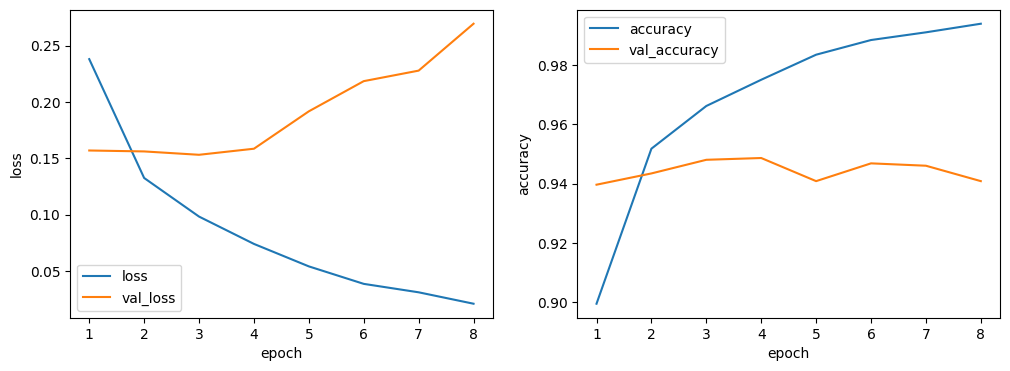

In [11]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.array(hist.epoch) + 1
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(epochs, hist.history['loss'], label='loss')
axs[0].plot(epochs, hist.history['val_loss'], label='val_loss')
axs[0].set_xticks(epochs)
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].legend()
axs[1].plot(epochs, hist.history['sparse_categorical_accuracy'],
            label='accuracy')
axs[1].plot(epochs, hist.history['val_sparse_categorical_accuracy'],
            label='val_accuracy')
axs[1].set_xticks(epochs)
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
axs[1].legend()
plt.show()

In [12]:
roberta_classifier.evaluate(test_ds)

782/782 ━━━━━━━━━━━━━━━━━━━━ 56s 68ms/step - loss: 0.1323 - sparse_categorical_accuracy: 0.9537


[0.13070203363895416, 0.9545999765396118]

## BERT의 경량화 모델 - DistilBERT

### 티처 모델 이해하기 – MLM을 위한 BERT

In [13]:
# BERT 베이스 MLM
vocab_size = 30522
num_layers = 12
num_heads = 12
hidden_dim = 768
dropout = 0.1
activation = 'gelu'
max_seq_len = 512

token_ids = keras.Input(shape=(None,))
segment_ids = keras.Input(shape=(None,))
padding_mask = keras.Input(shape=(None,))
mlm_position = keras.Input(shape=(None,))

token_embedding_layer = keras_nlp.layers.ReversibleEmbedding(vocab_size, hidden_dim)
token_embedding = token_embedding_layer(token_ids)

pos_embedding = keras_nlp.layers.PositionEmbedding(max_seq_len)(token_embedding)
seg_embedding = layers.Embedding(2, hidden_dim)(segment_ids)

x = layers.Add()((token_embedding, pos_embedding, seg_embedding))
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout)(x)

for _ in range(num_layers):
    x = transformer_encoder(x, padding_mask, dropout, activation)

mlm_position = keras.ops.expand_dims(mlm_position, axis=-1)
x = keras.ops.take_along_axis(x, mlm_position, axis=1)

x = layers.Dense(hidden_dim, activation='gelu')(x)
x = layers.LayerNormalization()(x)
outputs = token_embedding_layer(x, reverse=True)

model = keras.Model(inputs=(token_ids, segment_ids, padding_mask, mlm_position),
                    outputs=(outputs))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reversible_embeddi… │ (None, None,      │ 23,440,896 │ input_layer_2[1]… │
│ (ReversibleEmbeddi… │ 30522)            │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding… │ (None, None, 768) │    393,216 │ reversible_embed… │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 768) │      1,536 │ input_layer_3[1]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, None, 768) │          0 │ reversible_embed… │
│                     │                   │            │ position_embeddi… │
│                     │                   │            │ embedding_1[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 768) │      1,536 │ add_25[1][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_49          │ (None, None, 768) │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 768) │  2,362,368 │ input_layer_4[1]… │
│ (MultiHeadAttentio… │                   │            │ dropout_49[1][0], │
│                     │                   │            │ dropout_49[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_51          │ (None, None, 768) │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, None, 768) │          0 │ dropout_51[1][0], │
│                     │                   │            │ dropout_49[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 768) │      1,536 │ add_26[1][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, None,      │  2,362,368 │ layer_normalizat… │
│                     │ 3072)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, None, 768) │  2,360,064 │ dense_24[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_52          │ (None, None, 768) │          0 │ dense_25[1][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 109,483,776 (417.65 MB)

 Trainable params: 109,483,776 (417.65 MB)

 Non-trainable params: 0 (0.00 B)

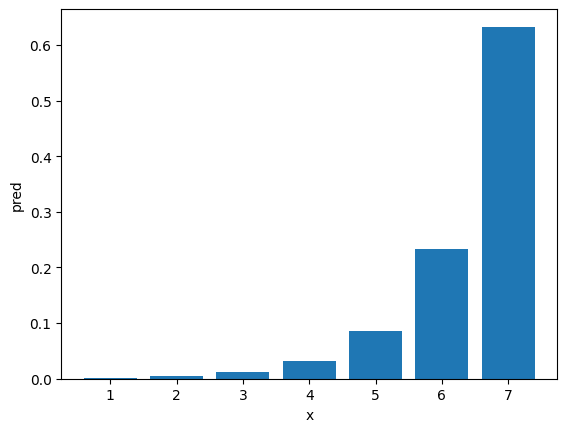

In [14]:
from scipy.special import softmax

x = np.array([1, 2, 3, 4, 5, 6, 7])
pred = softmax(x)

plt.bar(x, pred)
plt.xlabel('x')
plt.ylabel('pred')
plt.show()

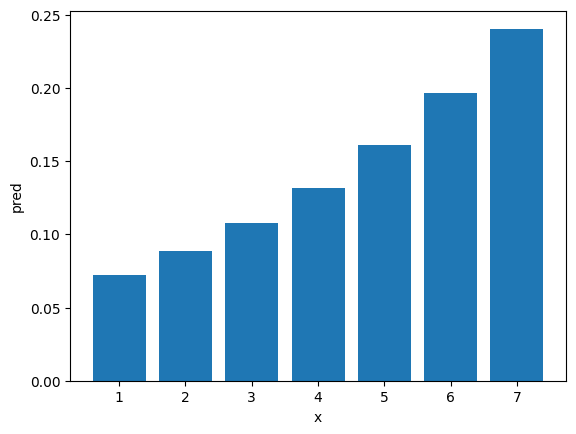

In [15]:
pred = softmax(x/5)

plt.bar(x, pred)
plt.xlabel('x')
plt.ylabel('pred')
plt.show()

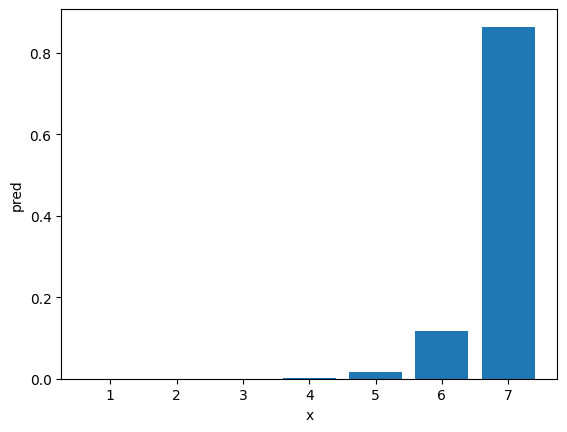

In [16]:
pred = softmax(x/0.5)

plt.bar(x, pred)
plt.xlabel('x')
plt.ylabel('pred')
plt.show()

### 스튜던트 모델 DistilBERT 사용해 보기

In [17]:
distilbert_classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    'distil_bert_base_en_uncased',
    num_classes=2)
distilbert_classifier.summary()

Preprocessor: "distil_bert_text_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from transformers import pipeline

In [19]:
pipe = pipeline("fill-mask", device=0,
                model="distilbert/distilbert-base-uncased")
pipe('The goal of life is [MASK].')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cuda:0


[{'score': 0.036191657185554504,
  'token': 8404,
  'token_str': 'happiness',
  'sequence': 'the goal of life is happiness.'},
 {'score': 0.030553549528121948,
  'token': 7691,
  'token_str': 'survival',
  'sequence': 'the goal of life is survival.'},
 {'score': 0.016977189108729362,
  'token': 12611,
  'token_str': 'salvation',
  'sequence': 'the goal of life is salvation.'},
 {'score': 0.016698457300662994,
  'token': 4071,
  'token_str': 'freedom',
  'sequence': 'the goal of life is freedom.'},
 {'score': 0.015267278999090195,
  'token': 8499,
  'token_str': 'unity',
  'sequence': 'the goal of life is unity.'}]

In [20]:
pipe = pipeline(
    'text-classification', device=0,
    model='distilbert/distilbert-base-uncased-finetuned-sst-2-english'
    )
pipe('The movie is a bit boring and easy to guess')

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


[{'label': 'NEGATIVE', 'score': 0.9997172951698303}]

### DistilBERT로 IMDB 영화 리뷰 텍스트의 감성 분류하기

In [21]:
!pip install datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" an

In [22]:
from datasets import load_dataset

ds = load_dataset("imdb")

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [23]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [24]:
test_slice = ds['test'].shuffle(seed=42).select(range(1000))

In [25]:
from evaluate import evaluator

task_evaluator = evaluator("text-classification")
task_evaluator.compute(
    model_or_pipeline=pipe,
    data=test_slice,
    metric="accuracy",
    input_column="text",
    label_column="label",
    label_mapping={"NEGATIVE": 0, "POSITIVE": 1}
    )

{'accuracy': 0.881,
 'total_time_in_seconds': 6.420584699000074,
 'samples_per_second': 155.74905509084516,
 'latency_in_seconds': 0.006420584699000074}

In [26]:
task_evaluator.compute(
    model_or_pipeline='distilbert/distilbert-base-uncased-finetuned-sst-2-english',
    data=test_slice,
    device=0,
    label_mapping={"NEGATIVE": 0, "POSITIVE": 1}
    )

Device set to use cuda:0


{'accuracy': 0.881,
 'total_time_in_seconds': 5.930149143000108,
 'samples_per_second': 168.62982294136575,
 'latency_in_seconds': 0.005930149143000107}

## 미니 프로젝트

In [27]:
import keras
from keras import layers
import keras_nlp

In [28]:
# DistilBERT 백본
vocab_size = 30522
num_layers = 6
num_heads = 12
hidden_dim = 768
dropout = 0.1
activation = 'gelu'
max_seq_len = 512

token_ids = keras.Input(shape=(None,))
padding_mask = keras.Input(shape=(None,))

token_embedding = layers.Embedding(vocab_size, hidden_dim)(token_ids)
pos_embedding = keras_nlp.layers.PositionEmbedding(max_seq_len)(token_embedding)

x = layers.Add()((token_embedding, pos_embedding))
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout)(x)

for _ in range(num_layers):
   x = transformer_encoder(x, padding_mask, dropout, activation)

outputs = x
distilbert_model = keras.Model(inputs=(token_ids, padding_mask),
                            outputs=(outputs))
distilbert_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, None, 768) │ 23,440,896 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding… │ (None, None, 768) │    393,216 │ embedding_2[0][0] │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_50 (Add)        │ (None, None, 768) │          0 │ embedding_2[0][0… │
│                     │                   │            │ position_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 768) │      1,536 │ add_50[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_92          │ (None, None, 768) │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 768) │  2,362,368 │ input_layer_7[0]… │
│ (MultiHeadAttentio… │                   │            │ dropout_92[0][0], │
│                     │                   │            │ dropout_92[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_94          │ (None, None, 768) │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_51 (Add)        │ (None, None, 768) │          0 │ dropout_94[0][0], │
│                     │                   │            │ dropout_92[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 768) │      1,536 │ add_51[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, None,      │  2,362,368 │ layer_normalizat… │
│                     │ 3072)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, None, 768) │  2,360,064 │ dense_49[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_95          │ (None, None, 768) │          0 │ dense_50[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_52 (Add)        │ (None, None, 768) │          0 │ dropout_95[0][0], │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 768) │      1,536 │ add_52[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 768) │  2,362,368 │ input_layer_7[0]

 Total params: 66,362,880 (253.15 MB)

 Trainable params: 66,362,880 (253.15 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
distilbert_backbone = keras_nlp.models.DistilBertBackbone.from_preset(
    'distil_bert_base_en_uncased')
distilbert_backbone.summary()

Model: "distil_bert_backbone"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, None, 768) │ 23,834,112 │ token_ids[0][0]   │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_layer_n… │ (None, None, 768) │      1,536 │ token_and_positi… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_dropout  │ (None, None, 768) │          0 │ embeddings_layer… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_0 │ (None, None, 768) │  7,087,872 │ embeddings_dropo… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_1 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_2 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_3 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_4 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_5 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 66,362,880 (253.15 MB)

 Trainable params: 66,362,880 (253.15 MB)

 Non-trainable params: 0 (0.00 B)